In [1]:
 import pandas_datareader as pdr

In [2]:
import os

In [3]:
df = pdr.get_data_tiingo('GOOG', api_key='8c20d3dcb50744d14b97326576601d1289f0e07c')

In [4]:
df.to_csv('GOOG.csv')

In [5]:
import pandas as pd

In [6]:
df=pd.read_csv('GOOG.csv')

In [7]:
df.head()

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,GOOG,2017-01-11 00:00:00+00:00,807.91,808.1500,801.37,805.00,1065936,807.91,808.1500,801.37,805.00,1065936,0.0,1.0
1,GOOG,2017-01-12 00:00:00+00:00,806.36,807.3900,799.17,807.14,1353057,806.36,807.3900,799.17,807.14,1353057,0.0,1.0
2,GOOG,2017-01-13 00:00:00+00:00,807.88,811.2244,806.69,807.48,1099215,807.88,811.2244,806.69,807.48,1099215,0.0,1.0
3,GOOG,2017-01-17 00:00:00+00:00,804.61,807.1400,800.37,807.08,1362115,804.61,807.1400,800.37,807.08,1362115,0.0,1.0
4,GOOG,2017-01-18 00:00:00+00:00,806.07,806.2050,800.99,805.81,1294407,806.07,806.2050,800.99,805.81,1294407,0.0,1.0


In [8]:
df.tail()

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
1254,GOOG,2022-01-04 00:00:00+00:00,2888.33,2932.2000,2876.3225,2911.01,1146389,2888.33,2932.2000,2876.3225,2911.01,1146389,0.0,1.0
1255,GOOG,2022-01-05 00:00:00+00:00,2753.07,2885.9600,2750.4700,2883.62,2482076,2753.07,2885.9600,2750.4700,2883.62,2482076,0.0,1.0
1256,GOOG,2022-01-06 00:00:00+00:00,2751.02,2793.7200,2735.2700,2749.95,1452452,2751.02,2793.7200,2735.2700,2749.95,1452452,0.0,1.0
1257,GOOG,2022-01-07 00:00:00+00:00,2740.09,2765.0949,2715.7800,2758.10,970412,2740.09,2765.0949,2715.7800,2758.10,970412,0.0,1.0
1258,GOOG,2022-01-10 00:00:00+00:00,2771.48,2772.8000,2662.8100,2701.98,1693740,2771.48,2772.8000,2662.8100,2701.98,1693740,0.0,1.0


In [9]:
df1=df.reset_index()['close']

In [10]:
df1.shape

(1259,)

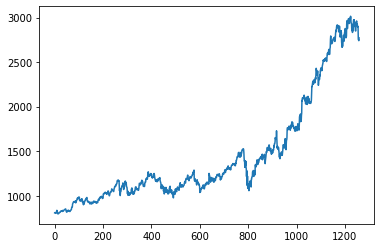

In [11]:
import matplotlib.pyplot as plt
plt.plot(df1)

In [12]:
### LSTM are senstive to the scale data. so we apply MinMax scaler

In [13]:
import numpy as np

In [14]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [15]:
df1.shape

(1259, 1)

In [16]:
print(df1)

[[0.00550601]
 [0.00480733]
 [0.00549249]
 ...
 [0.88137851]
 [0.87645172]
 [0.89060102]]


In [17]:
### Spliting Data set into Train and Test split
training_size=int(len(df1)*0.65)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]

In [18]:
training_size,test_size

(818, 441)

In [19]:
import numpy
#convert an array values into dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0] ###i=0, 0,1,2,3
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return numpy.array(dataX), numpy.array(dataY)

In [20]:
###reshape into X=t,t+1, t+2, t+3 and Y=t+4
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [21]:
print(X_train)

[[0.00550601 0.00480733 0.00549249 ... 0.07719457 0.08109363 0.08473575]
 [0.00480733 0.00549249 0.00401851 ... 0.08109363 0.08473575 0.08153086]
 [0.00549249 0.00401851 0.00467661 ... 0.08473575 0.08153086 0.08350068]
 ...
 [0.22677863 0.22641803 0.23248523 ... 0.14656173 0.13621233 0.17634782]
 [0.22641803 0.23248523 0.24303748 ... 0.13621233 0.17634782 0.17616301]
 [0.23248523 0.24303748 0.23665024 ... 0.17634782 0.17616301 0.18687753]]


In [22]:
print(X_train.shape), print(y_train.shape)

(717, 100)
(717,)


(None, None)

In [23]:
print(X_test.shape), print(ytest.shape)

(340, 100)
(340,)


(None, None)

In [24]:
# Reshape input to be [samples, time steps, features] which is required for LSTM
X_train=X_train.reshape(X_train.shape[0],X_train.shape[1], 1)
X_test=X_test.reshape(X_test.shape[0],X_test.shape[1], 1)

In [28]:
### Creating the LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [29]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [30]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 100, 50)           10400     
_________________________________________________________________
lstm_4 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
lstm_5 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [31]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Train on 717 samples, validate on 340 samples
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/100
717/717 [==============================] - 5s 6ms/sample - loss: 0.0077 - val_loss: 0.1527
Epoch 2/100
717/717 [==============================] - 3s 4ms/sample - loss: 0.0022 - val_loss: 0.0870
Epoch 3/100
717/717 [==============================] - 3s 4ms/sample - loss: 0.0015 - val_loss: 0.0999
Epoch 4/100
717/717 [==============================] - 3s 4ms/sample - loss: 9.4523e-04 - val_loss: 0.0309
Epoch 5/100
717/717 [==============================] - 3s 4ms/sample - loss: 6.3844e-04 - val_loss: 0.0030
Epoch 6/100
717/717 [==============================] - 3s 4ms/sample - loss: 5.7040e-04 - val_loss: 0.0022
Epoch 7/100
717/717 [==============================] - 3s 4ms/sample - loss: 5.9953e-04 - val_loss: 0.0054
Epoch 8/100
717/717 [==============================] - 3s 4ms/sample - loss: 5.0390e-04 - val_loss: 0.0077
Epoch 9/100
717/

In [33]:
import tensorflow as tf

In [34]:
## Lets do the predictiona nd performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [35]:
## transform back to the original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [36]:
## Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

1139.8846209733606

In [37]:
## Test data RMSE
math.sqrt(mean_squared_error(ytest,test_predict))

2253.422630901302

<function matplotlib.pyplot.show(*args, **kw)>

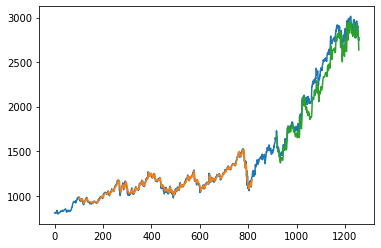

In [38]:
## Plotting
# shift train predictions for plotting
look_back=100
trainPredictPlot = numpy.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
#shift test predictions for plotting
testPredictPlot = numpy.empty_like(df1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
#plot baseline and prediction
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show

In [39]:
len(test_data)

441

In [40]:
x_input=test_data[341:].reshape(1,-1)
x_input.shape

(1, 100)

In [41]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [42]:
# Demonstrate Prediction for Next 10 days
from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if (len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day input {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print temp_input
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
        
print(lst_output)

[0.8562377]
101
1 day input [0.88936594 0.91336881 0.9250795  0.93005136 0.92259583 0.94448013
 0.95276506 0.95269745 0.95612321 0.9414916  0.94650403 0.95321131
 0.94748218 0.94775263 0.92077476 0.93469417 0.93416228 0.95038957
 0.94288445 0.91665033 0.89459473 0.90026978 0.91191737 0.91992283
 0.92719356 0.9169884  0.86905478 0.85406257 0.84274403 0.87156551
 0.84724711 0.86899168 0.87960252 0.89611379 0.90396149 0.89306666
 0.8738238  0.8845248  0.91618605 0.91855703 0.93014602 0.93791258
 0.92522825 0.92852329 0.89106079 0.89239504 0.90049967 0.96140159
 0.95871056 0.97801653 0.93747986 0.95631253 0.96466958 0.98173528
 0.98676574 0.98776192 0.98683336 0.9631911  0.96429095 0.99041238
 0.98809097 0.98527824 0.98515203 1.         0.99318003 0.96727046
 0.96437208 0.96401598 0.92875318 0.95857533 0.92556181 0.91804317
 0.93750239 0.92617935 0.9376827  0.97590698 0.98207335 0.97653354
 0.98166316 0.96389879 0.9482665  0.96988485 0.9470765  0.92872614
 0.92510655 0.94150513 0.96610299 